In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import re 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Import traffic and weather data

In [ ]:
# import dati waze
url = "https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/waze_reports/waze_mobility.csv"

file = pd.read_csv(url,index_col="date")
df_waze = file[(file["country"] == "Italy") & (file["city"] == "Total")]
df_waze.head()

In [ ]:
# import dati meteo
url = "https://storage.googleapis.com/covid19-open-data/v3/location/IT.csv"
file = pd.read_csv(url,index_col="date")
df_meteo = file["average_temperature_celsius"]
df_meteo.head()

In [ ]:
df_tot = df_waze.join(df_meteo)
df = df_tot[["driving_waze","average_temperature_celsius"]]
df.rename(columns={'driving_waze': 'waze', 'average_temperature_celsius': 'temp'}, inplace=True)
df.head()

In [83]:
data = df.copy()
data.reset_index(level=0, inplace=True)
# remove all nans
#data.dropna(axis=0, how = "any", inplace=True )
data.head()

,date,waze,temp
0,2020-03-01,-28.0,11.618056
1,2020-03-02,-17.0,11.839506
2,2020-03-03,-15.0,9.401235
3,2020-03-04,-20.0,8.783951
4,2020-03-05,-25.0,9.080247


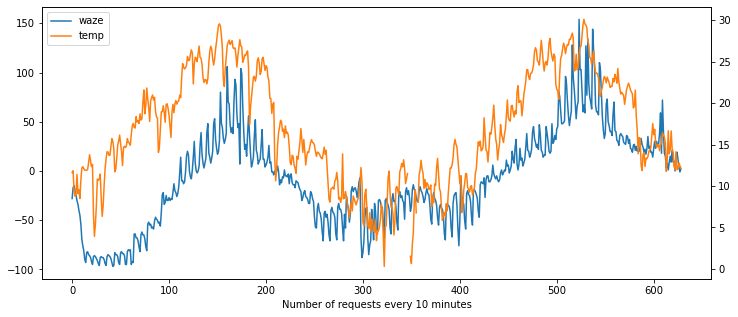

In [84]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = data.waze.plot()
ax2 = data.temp.plot(secondary_y=True)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [85]:
#split the dataset
test_size = 70
train_df = data[:-test_size]
test_df = data[-test_size:]

In [86]:
date_col = 'date'
response_col = 'waze'

In [229]:
# save results in dataframe
tabella = test_df[[date_col, response_col]]
tabella.rename(columns={'date': 'Date', 'waze': 'Actual'}, inplace=True)
tabella.head()

,Date,Actual
559,2021-09-12,70.0
560,2021-09-13,41.0
561,2021-09-14,40.0
562,2021-09-15,31.0
563,2021-09-16,30.0


# Functions for models

In [159]:
def table_results(pred, mod, table): 
    # store predictions and actual values in table
    pred_df = pd.DataFrame(pred)
    pred_df.index = table.index
    pred_df.columns = [mod]
    return table.join(pred_df)

In [12]:
def mape(actual, pred): 
    # compute mean prediction error
    actual, pred = np.array(actual), np.array(pred)
    actual[actual==0]=['nan']
    return np.nanmean(np.abs((actual - pred) / actual)) * 100

In [188]:
def getModelDict(train, s = 1, seed = 8888):
    # dictionary of orbit model specifications
    modelDict = {'ETSFull': ETSFull(
                    response_col=response_col,
                    date_col=date_col,
                    seasonality=s,
                    seed=seed
                    ),
                'DLTMAP_Linear': DLTMAP(
                        response_col=response_col,
                        date_col=date_col,
                        seasonality=s,
                        seed=seed
                        ),
                'DLTMAP_LogLin': DLTMAP(
                                response_col=response_col,
                                date_col=date_col,
                                seasonality=s,
                                seed=seed,
                                global_trend_option='loglinear'
                                ),
                'DLTMAP_Logistic': DLTMAP(
                                    response_col=response_col,
                                    date_col=date_col,
                                    seasonality=s,
                                    seed=seed,
                                    global_trend_option='logistic'
                                    ),
                 
                'DLTFull': DLTFull(
                            response_col=response_col,
                            date_col=date_col,
                            seasonality=s,
                            seed=seed,
                            num_warmup=seed,
                        ),
                 # LGT requires positive data
                 'LGTFull': LGTFull(
                            response_col=response_col,
                            date_col=date_col,
                            seasonality=s,
                            seed=seed,
                        ),
                 'LGTAggregation': LGTAggregated(
                                    response_col=response_col,
                                    date_col=date_col,
                                    seasonality=s,
                                    seed=seed,
                                )}
    return modelDict

In [195]:
def runTheModel(df_train, df_test, model, modName, date_col, response_col, decompose=False):
    # fit orbit models
    model.fit(df_train)
    if not decompose:
        pred = model.predict(df_test[[date_col]]).prediction.unique()
    else:
        pred = model.predict(df_train, decompose=True)
        vis = plot_predicted_components(pred, date_col, is_visible=False,
                                        plot_components=['prediction', 'trend', 'seasonality'])
        return vis, pred
        
    error = mape(df_test[response_col], pred)
    prediction_df = pd.DataFrame.from_dict({'Date': df_test[date_col], 'Actual': df_test[response_col], 'Prediction': pred, 'MAPE': error, 'Model': modName})

    return prediction_df

# ARIMA

In [163]:
m = auto_arima(train_df[[response_col]])
pred_arima = m.predict(test_df.shape[0])
error_arima = mape(test_df[response_col], pred)

In [230]:
# save results
tabella = table_results(pred = pred_arima, mod = "Arima", table = tabella)

errors = {}
errors["Arima"] = error_arima

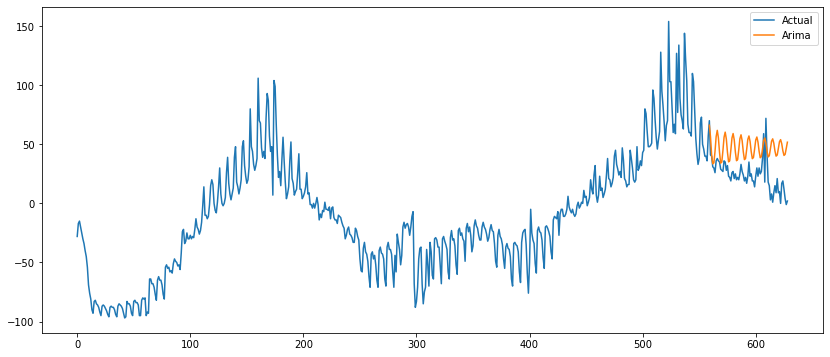

In [150]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(data["waze"], label = "Actual")
ax.plot(tabella.Arima, label = "Arima")

plt.legend()
plt.show()

# Prophet

Generalized additive model (GAM) with three components: trend, seasonality and holidays.

$ y_t = g_t + s_t + h_t + \varepsilon_t$

where $g_t$ can be a linear or logistic growth curve, $s_t$ is the seasonality and $h_t$ is the holiday effect. Change points to fit the trend term can be supplied manually.

In [87]:
from prophet import Prophet

In [88]:
train_prophet = train_df[["date", "waze"]]
train_prophet.rename(columns={'date': 'ds', 'waze': 'y'}, inplace=True)

In [89]:
m = Prophet()
m.fit(train_prophet)
future = m.make_future_dataframe(periods=test_size)
forecast = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [168]:
pred_series = forecast["yhat"]
pred_prophet = pred_series[-71:-1]
error_prophet = mape(test_df[response_col], pred)

In [231]:
tabella = table_results(pred = pred_prophet, mod = "Prophet", table = tabella)

errors["Prophet"] = error_prophet

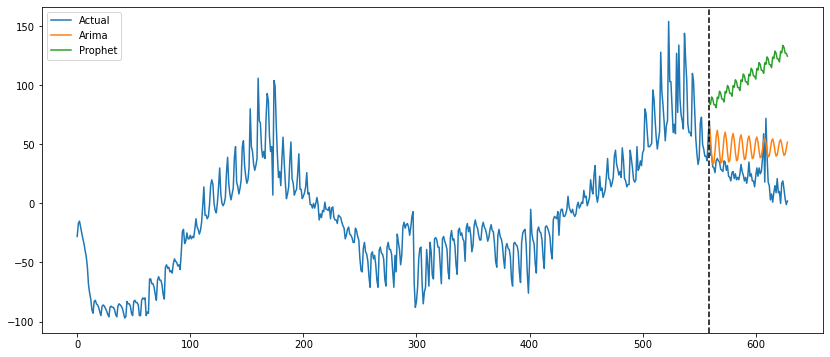

In [181]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(data["waze"], label = "Actual")
ax.plot(tabella.Arima, label = "Arima")
ax.plot(tabella.Prophet, label = "Prophet")

plt.axvline(x=tabella.index[0], color='k', linestyle='--')

plt.legend()
plt.show()

In [223]:
# save results
for j in range(len(predictions)):
    fcst = predictions[j].Prediction
    name = predictions[j].Model.iloc[0]
    tabella = table_results(pred = fcst, mod = name, table = tabella)

# Damped local trend (DLT) model

Suited for $y_t \in \mathbb{R}$

$y_t = \mu_t + s_t + r_t + \varepsilon_t$

$\mu_t = D(t) + l_{t-1} + \theta b_{t-1}$

where
* $D(t)$ can be a linear, log-linear or logistic linear trend;
* $r_t = \Sigma_j \beta_j x_{jt}$, $\beta_j \sim N(\mu_j, \sigma_j)$, is a regression component which can be used to forecast with exogenous regressors (such as holidays); 

In [11]:
import pmdarima
from orbit.models.dlt import ETSFull, DLTMAP, DLTFull
from orbit.models.lgt import LGTMAP, LGTFull, LGTAggregated
from orbit.diagnostics.plot import plot_predicted_components
from pmdarima.arima import auto_arima

In [189]:
# initialize orbit models
models = getModelDict(train_df)

In [193]:
# select DLT models
selection = ['DLTMAP_Linear', 'DLTMAP_LogLin', 'DLTMAP_Logistic', 'DLTFull']
models_sel = {}
for m in selection:
    if m in models: 
        models_sel[m] = models[m]

In [197]:
# Run the models
predictions = []
for mod in models_sel:
        try: 
            print('running', mod)
            predictions.append(runTheModel(train_df, test_df, models[mod], mod, date_col, response_col))
        except ValueError as e: 
            print("skipping", mod)
            print(e)
            pass

running DLTMAP_Linear
running DLTMAP_LogLin
skipping DLTMAP_LogLin
operands could not be broadcast together with shapes (70,) (12,) 
running DLTMAP_Logistic
running DLTFull


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [233]:
# save results
for j in range(len(predictions)):
    fcst = predictions[j].Prediction
    name = predictions[j].Model.iloc[0]
    try: 
        tabella = table_results(pred = fcst, mod = name, table = tabella)
    except ValueError: 
        print("value already in table")
        pass
    err = predictions[j].MAPE.iloc[0]
    errors[name] = err

In [263]:
all_cols = list( tabella.columns )
result = [ re.search("DLT", col) for col in all_cols ] 

model_names = []
for res in result: 
    if res is not None: 
        model_names.append(res.string)

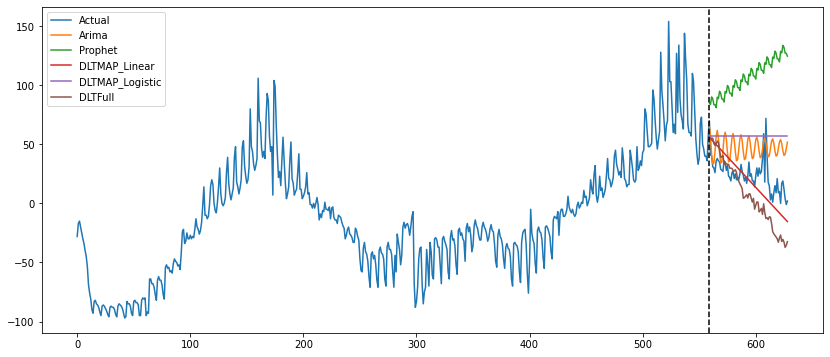

In [264]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(data["waze"], label = "Actual")
ax.plot(tabella.Arima, label = "Arima")
ax.plot(tabella.Prophet, label = "Prophet")

for model in model_names:  
    ax.plot(tabella[model], label=model)

plt.axvline(x=tabella.index[0], color='k', linestyle='--')

plt.legend()
plt.show()

# Compare models

<BarContainer object of 5 artists>

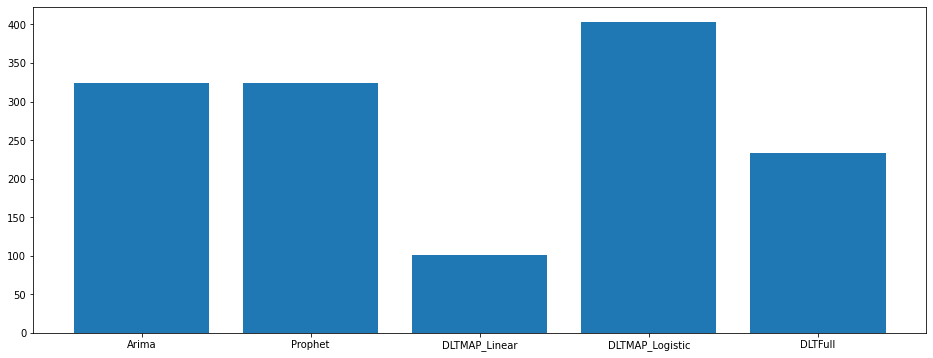

In [282]:
# plot prediction error
fig, ax = plt.subplots(figsize=(16,6))
keys = errors.keys()
values = errors.values()

plt.bar(keys, values)

In [285]:
# Decomposition of best ranking model 
best = min(errors, key=errors.get)

best_pred, best_dec = runTheModel(train_df, test_df, models[best], best, date_col, response_col, decompose = True)

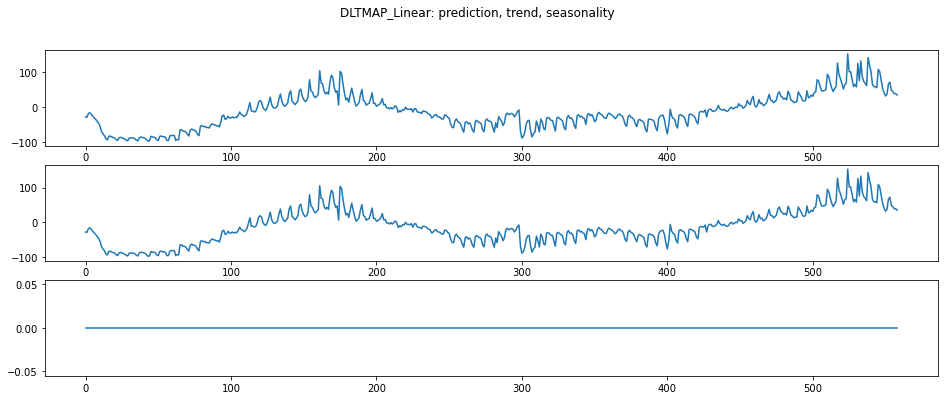

In [290]:
fig, axs = plt.subplots(3, figsize=(16,6))
fig.suptitle(best + ': prediction, trend, seasonality')

axs[0].plot(best_dec["prediction"])
axs[1].plot(best_dec["trend"])
axs[2].plot(best_dec["seasonality"])